# Myriam Marending: Ships and economic activity: a starter

The underlying idea of this sample code is that ships play an important role in international trade and as such are a proxy for economic activity locally as well as at the aggregate. Sea transport reflecting the import and exports of goods is responsible for about 80 percent of world trade. While there exist datasets on reported ship activity, a classification based on satellite images adds an independent source of verification. 
The case chosen trains a ship classifier on a sample of 4000 images from Planet that are labelled either as "ship" or "no-ship", which in a second step is used to classify a sample satellite image of a port in Lagos, Nigeria taken from Sentinel-2. The task faces several identification challenges, on the one hand, the algorithm is trained and tested on a different satellite dataset than it is used to predict on, this implies that spectral information is less valuable. On the other hand, the "ship" and "no-ship" images are collected over the San Francisco Bay and San Pedro Bay areas of California, whereas the port data is from Lagos. Likely the ship types and landscapes are different across these two areas, stressing the importance of learning the general features of a ship to be identifiable in a wide context of ports globally.

In [1]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from scipy import ndimage
import pyjeo as pj

from osgeo import gdal, ogr
import rasterio as rio
import rasterio.plot as rioplot

### **1. Data sources**
The satellite images of the port in Lagos, Nigeria, are taken from Sentinel-2. Using the RGB band, monthly for February, March, May and June 2022. To train the ship detection algorithm, a sample of 4000 Planet images of 80x80 RGB is considered and stored as a list of 19200 integers. The "ship" class contains 1000 images that are as good as centered on the body of a single ship (varies along dimensions of: size, orientation). The remaining 3000 images are "no-ship" of randomly sampled landcover features or half ships (only partially visible) from the same area in California.

#### 1.1 Port satellite images


In [2]:
## Using the Pyjeo library to create a Geotiff dataset of the original Sentinel-2 data

path = 'Sentinel2'
files = sorted(glob.glob(path + '/T31NDH_*_TCI_10m.jp2'))
#print(files)

# limit to extent of interest
extent = 'POLYGON((2.3 6.4, 2.5 6.4, 2.5 6.3, 2.3 6.4))'
extent_vect = pj.JimVect(wkt=extent)

# iterate across months
jim = None
for file in files:
    if jim is None:
        jim = pj.Jim(file, bbox=extent_vect.properties.getBBox(), t_srs='EPSG:4326')
        jim.pixops.convert('GDT_UInt16')
    else:
        jim1 = pj.Jim(file, bbox=extent_vect.properties.getBBox(), t_srs='EPSG:4326')
        jim1.pixops.convert('GDT_UInt16')
        jim.geometry.stackBand(jim1)  
print(jim.properties.nrOfBand())
#plt.imshow(jim.np())

# save dataset
jim.io.write("data.tif", co=["COMPRESS=LZW"])
del jim, jim1

ERROR 6: Update from inline definition not supported


12


In [3]:
# Load saved images of Lagos port
ports = rio.open('./data.tif')
#print(ports.meta)

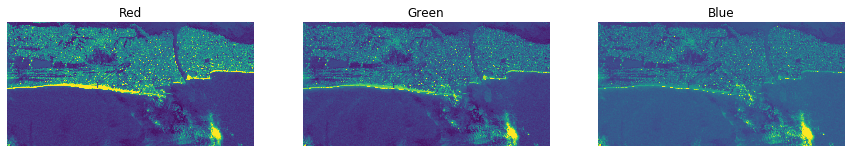

In [4]:
# a look at the three colour channels in February
channellist = [(0, 'Red'), (1, 'Green'), (2, 'Blue')]
plt.figure(figsize = (15,15))
for i, k in channellist:
    plt.subplot(1,3,i+1)
    plt.title(k)
    plt.imshow(ports.read(i+1))
    plt.axis("off")

In [5]:
# Format ports data
portFeb = ports.read()[0:3]
portMarch = ports.read()[4:7]
portMay = ports.read()[7:10]
portJune = ports.read()[10:13]
portFeb.shape

# only use February for now
del ports, portMarch, portMay, portJune

In [6]:
# divide into tiles of same resolution as ship images
M = 80
N = 80
portFeb_tiles=[]
for x in range(0, portFeb.shape[1], M):
    for y in range(0, portFeb.shape[2], N):
        if portFeb[:, x:x+M, y:y+N].shape[1]==80 and portFeb[:, x:x+M, y:y+N].shape[2]==80:
            portFeb_tiles.append(portFeb[:, x:x+M, y:y+N])

portFeb_tiles = np.stack(portFeb_tiles)
print(portFeb_tiles.shape)

# convert to float (to be used in the prediction later)
portFeb_tiles = portFeb_tiles.astype(float)

(351, 3, 80, 80)


#### 1.2 Ship sample data

In [7]:
## Ship samples, select variables
with open('./ship/shipsnet.json') as file: df = json.load(file)
ship = pd.DataFrame(df)

In [8]:
# get number of integers per list
print(len(ship["data"].iloc[0]))
# count ships and no-ship 
print(ship["labels"].value_counts())

19200
0    3000
1    1000
Name: labels, dtype: int64


In [9]:
# convert to numpy array 
images = np.array(df['data']).astype('uint8')
labels = np.array(df['labels']).astype('uint8')
images.shape

(4000, 19200)

In [11]:
# reshape and transpose images and labels
images2 = images.reshape([-1, 3, 80, 80]).transpose([0,2,3,1])
print(images2.shape)

from keras.utils import to_categorical
labels2 = to_categorical(labels, num_classes=2)
labels2.shape

(4000, 80, 80, 3)


(4000, 2)

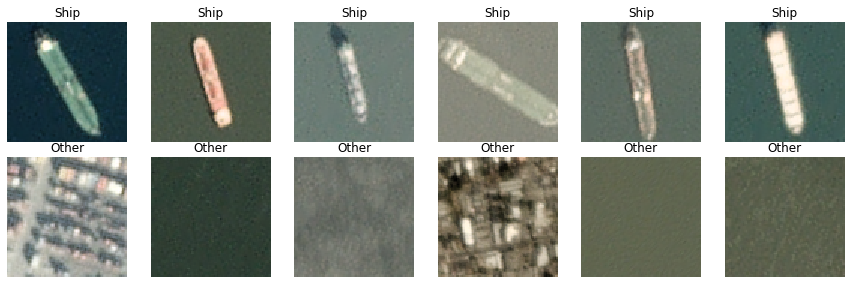

In [12]:
# sample plots of "ship" and "no-ship" labelled categories among images
imageNoShip = images2[labels==0]
imageShip = images2[labels==1]

# plot several images
def plot(a,b):
    plt.figure(figsize=(15, 15))
    for i, k in enumerate(range(1,13)):
        if i < 6:
            plt.subplot(2,6,k)
            plt.title('Ship')
            plt.imshow(imageShip[i+20])
            plt.axis("off")
        else:
            plt.subplot(2,6,k)
            plt.title('Other')
            plt.imshow(imageNoShip[i+20])
            plt.axis("off")
    plt.subplots_adjust(bottom=0, top=0.25, hspace=0)
plot(imageNoShip, imageShip)

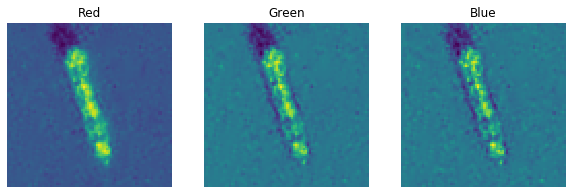

In [13]:
# a look at the three colour channels
channellist = [(0, 'Red'), (1, 'Green'), (2, 'Blue')]
plt.figure(figsize = (10,10))
for i, k in channellist:
    plt.subplot(1,3,i+1)
    plt.title(k)
    plt.imshow(images2[labels==1][99][ : , : , i])
    plt.axis("off")

In [14]:
## normalise data to range 0-1 (dividing by 255)
images2 = images2 / 255
images2[1][1][1]

array([0.28627451, 0.3254902 , 0.27058824])

### **2 Training and learning from the ship sample**

In [15]:
# splitting into training and test datasets
from sklearn.model_selection import train_test_split
train_images, test_images, train_labels, test_labels = train_test_split(images2, labels, test_size=0.20, random_state=0)

# check dimensions data
print('Training data shape : ', train_images.shape, train_labels.shape)
print('Testing data shape : ', test_images.shape, test_labels.shape)

Training data shape :  (3200, 80, 80, 3) (3200,)
Testing data shape :  (800, 80, 80, 3) (800,)


0


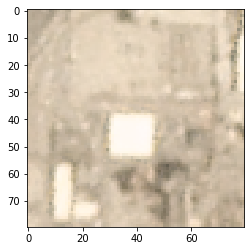

In [38]:
# check match of images and labels
plt.imshow(train_images[300])
print(train_labels[300])

#### **2.1 Simple CNN**
(Note: tensorflow is used as PyTorch seems to be too heavy in the current configuration of the data as the Kernel keeps on dying.)

In [39]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Activation

In [19]:
# delete existing models
if 'model' in globals():
    print('Deleting "model"')
    del model
    
# initiate model and add layers
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(80, 80, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid')) # output layer that makes a single value prediction
# output neuron will contain value from 0-1 where 0 for 'no-ship' and 1 'ship'

# print summary of model
model.summary()

Deleting "model"
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 78, 78, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 39, 39, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 37, 37, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 18, 18, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 flatten_1 (Flatten)         (None, 1

In [20]:
# compile and train the model
model.compile(optimizer=tf.optimizers.RMSprop(learning_rate=0.001, momentum=0.0), 
              loss='binary_crossentropy', metrics=['accuracy'])

In [21]:
history = model.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels))

Epoch 1/10


2022-06-27 19:17:12.929236: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 245760000 exceeds 10% of free system memory.


100/100 [==============================] - 13s 128ms/step - loss: 0.4425 - accuracy: 0.8475 - val_loss: 0.2840 - val_accuracy: 0.8850
Epoch 2/10
100/100 [==============================] - 13s 129ms/step - loss: 0.2341 - accuracy: 0.9119 - val_loss: 0.1960 - val_accuracy: 0.9125
Epoch 3/10
100/100 [==============================] - 13s 131ms/step - loss: 0.1723 - accuracy: 0.9350 - val_loss: 0.1459 - val_accuracy: 0.9388
Epoch 4/10
100/100 [==============================] - 13s 129ms/step - loss: 0.1339 - accuracy: 0.9469 - val_loss: 0.1423 - val_accuracy: 0.9550
Epoch 5/10
100/100 [==============================] - 13s 132ms/step - loss: 0.1038 - accuracy: 0.9609 - val_loss: 0.0801 - val_accuracy: 0.9700
Epoch 6/10
100/100 [==============================] - 13s 134ms/step - loss: 0.0791 - accuracy: 0.9759 - val_loss: 0.0945 - val_accuracy: 0.9762
Epoch 7/10
100/100 [==============================] - 16s 161ms/step - loss: 0.0650 - accuracy: 0.9806 - val_loss: 0.0930 - val_accuracy: 0.9

25/25 - 1s - loss: 0.0940 - accuracy: 0.9825 - 589ms/epoch - 24ms/step


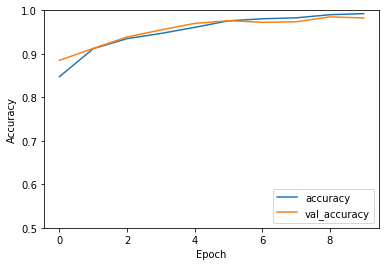

In [22]:
# Evaluate
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

The simple CNN reached a test accuracy of 98 percent. 

In [23]:
# show an evaluation based on predictions using the test images
from sklearn.metrics import classification_report
predictions = model.predict(test_images)
print(classification_report(test_labels, predictions.round()))

25/25 [==============================] - 1s 27ms/step
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       581
           1       0.98      0.95      0.97       219

    accuracy                           0.98       800
   macro avg       0.98      0.97      0.98       800
weighted avg       0.98      0.98      0.98       800



The 581 images of the testing dataset labelled as "no-ship" were accurately classified in 98 percent of the cases, whereas the ship images (219) were classified at the same accuracy. Overall it suggest that a simple CNN can learn well the differences between ship and no-ship in the California images.

In [24]:
# save the model
model.save("./model/CNNsimple_ship.h5")

#### **2.2 Predict ships in Lagos with simple CNN**

In [25]:
portFeb_tiles.shape

(351, 3, 80, 80)

In [26]:
# reshape and transpose
ports2 = portFeb_tiles.reshape([-1, 3, 80, 80]).transpose([0,2,3,1])
print(ports2.shape)

(351, 80, 80, 3)


In [27]:
# predict using the simple CNN 
predictions1 = model.predict(ports2)

11/11 [==============================] - 0s 28ms/step


In [28]:
# number of predicted ships
np.count_nonzero(predictions1 == 1)

1

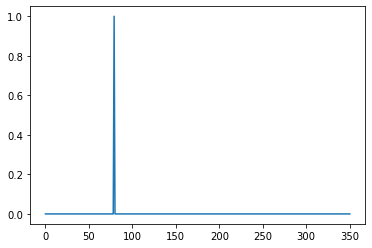

In [30]:
# plot distribution of predictions
plt.plot(predictions1)

The prediction on the Sentinel images are rather poor. By eye I identified 6 ships in month February 2022, yet simple CNN trained algorithm predicts 1. 

#### **2.3 Update the simple CNN using Adam**

In [32]:
# delete existing models
if 'model' in globals():
    print('Deleting "model"')
    del model
    
# initiate model and add layers
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(80, 80, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid')) # output layer that makes a single value prediction
# output neuron will contain value from 0-1 where 0 for 'no-ship' and 1 'ship'

# print summary of model
model.summary()

Deleting "model"
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 78, 78, 32)        896       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 39, 39, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 37, 37, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 18, 18, 64)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 

In [33]:
# compile and train the model
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001), 
              loss='binary_crossentropy', metrics=['accuracy'])

In [34]:
history = model.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels))

2022-06-27 19:25:30.505276: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 245760000 exceeds 10% of free system memory.


Epoch 1/10
100/100 [==============================] - 14s 133ms/step - loss: 0.3650 - accuracy: 0.8516 - val_loss: 0.2176 - val_accuracy: 0.9075
Epoch 2/10
100/100 [==============================] - 14s 142ms/step - loss: 0.2023 - accuracy: 0.9184 - val_loss: 0.2128 - val_accuracy: 0.9062
Epoch 3/10
100/100 [==============================] - 16s 162ms/step - loss: 0.1572 - accuracy: 0.9334 - val_loss: 0.1419 - val_accuracy: 0.9262
Epoch 4/10
100/100 [==============================] - 14s 145ms/step - loss: 0.1130 - accuracy: 0.9566 - val_loss: 0.1356 - val_accuracy: 0.9413
Epoch 5/10
100/100 [==============================] - 15s 147ms/step - loss: 0.0916 - accuracy: 0.9663 - val_loss: 0.0776 - val_accuracy: 0.9825
Epoch 6/10
100/100 [==============================] - 17s 169ms/step - loss: 0.0601 - accuracy: 0.9803 - val_loss: 0.0607 - val_accuracy: 0.9812
Epoch 7/10
100/100 [==============================] - 16s 160ms/step - loss: 0.0505 - accuracy: 0.9850 - val_loss: 0.0491 - val_ac

25/25 - 1s - loss: 0.0537 - accuracy: 0.9887 - 1s/epoch - 54ms/step


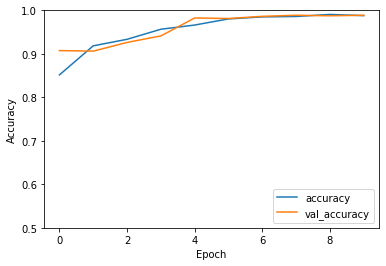

In [35]:
# Evaluate
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

The updated CNN using Adam as optimiser reaches a slightly higher test accuracy compared to the previous one.

In [44]:
# save the model
model.save("./model/CNNadam_ship.h5")

#### **2.4 Predict ships in Lagos with updated CNN**

In [45]:
# predict using the simple CNN 
predictions2 = model.predict(ports2)

11/11 [==============================] - 0s 39ms/step


In [46]:
# share with higher than 50 percent prediction value to be a ship.
np.count_nonzero(predictions2 == 1)

2

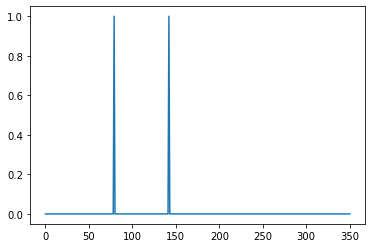

In [47]:
# plot distribution of predictions
plt.plot(predictions2)

The predictions for the Lagos port find now two ships compared to the earlier model.